# Data description and analysis 

This notebook contains the data description, analysis, and the figures presented in the manuscript. It also contains explanations about the dataset and the helper functions.

### Import the libraries and the data

In [2]:
import json
import sys
import pandas as pd
import collections 
import os
import numpy as np
from itertools import chain
from itertools import combinations
sys.path.insert(0, '..')
from src.experiment_utils.helper_classes import token, span, repository
from src.d02_corpus_statistics.corpus import Corpus
from definitions import ROOT_DIR
from pyannote.core import Segment
import matplotlib.pyplot as plt

## Descriptive statistics

In [3]:
dataframe_dir = os.path.join(ROOT_DIR,'data/02_processed_to_dataframe', 'preprocessed_dataframe_test.pkl')
stat_df = pd.read_pickle(dataframe_dir)

In [4]:
stat_corpus = Corpus(stat_df)

### Number of articles 

All articles (including recital ("Whereas") and front):

In [5]:
len(stat_df) 

448

All articles without the preamble (recital ("Whereas") and front):

In [6]:
len(stat_corpus.df) 

412

### Total number of annotated spans

There are three ways to compute the number of span annotations in the corpus (several annotations for the same span are counted separately.)

We are only interested in the curation and therfore we can subset the dataframe to exclude the annotation by the annotators:

In [7]:
total_corpus_dir = repository()
stat_corpus.get_span_count(total_corpus_dir, annotators = 'Curation')

20577

This is the same as the following, since the curation is the default:

In [8]:
stat_corpus.get_span_count(total_corpus_dir)

20577

To check that this is true, we compare this to all the tags present in the dataframe:

In [8]:
len(list(chain.from_iterable(stat_corpus.df['Curation'])))

20577

### Annotated tokens to total tokens

As above, all calculations are done twice with different methods for more robustness.

#### Total number of tokens in the dataset

In [9]:
print(stat_corpus.get_token_count_from_repository(total_corpus_dir))
print(len(list(chain.from_iterable(stat_corpus.df['Tokens']))))

173438
173438


#### Total number of annotated tokens 
This is summing over all tokens that have at least one annotation.

In [10]:
print(sum(stat_corpus.get_label_count_per_token_distro(total_corpus_dir, return_format = 'list')[1:]))
print(stat_corpus.get_token_count_from_span_list(conditional_rep = total_corpus_dir))

52298
52298


### Token label count distribution
The following two methods count how many annotations (spans) there are per token, and display the count distribution.

In [11]:
stat_corpus.get_label_count_per_token_distro(total_corpus_dir, return_format = 'dict')

{0: 121140, 1: 44548, 2: 6967, 3: 707, 4: 70, 5: 6}

In [12]:
stat_corpus.get_label_count_per_token_distro(total_corpus_dir, return_format = 'list')

[121140, 44548, 6967, 707, 70, 6]

### Total number of annotated articles

The number of annotated articles (which are separate documents in the corpus).

#### Annotated articles of all articles
Some recitals have initially been annotated. They were excluded though from the main analysis later.

In [13]:
# Assign the number of spans in each article to a new column
stat_df['Curationlength'] = stat_df.apply(lambda x: len(x['Curation']), axis=1)
# Count those where annotations were made
sum(stat_df['Curationlength']!=0)

430

#### Annotated articles of main corpus

In [14]:
# Assign the number of spans in each article to a new column
stat_corpus.df['Curationlength'] = stat_corpus.df.apply(lambda x: len(x['Curation']), axis=1)
# Count those where annotations were made
sum(stat_corpus.df['Curationlength']!=0)

412

## Distribution of annotations

### Span length

#### Span length in number of tokens
Here we compute the distribution of the length of the spans in the curated set. From here on the analysis is only done without recital and front.

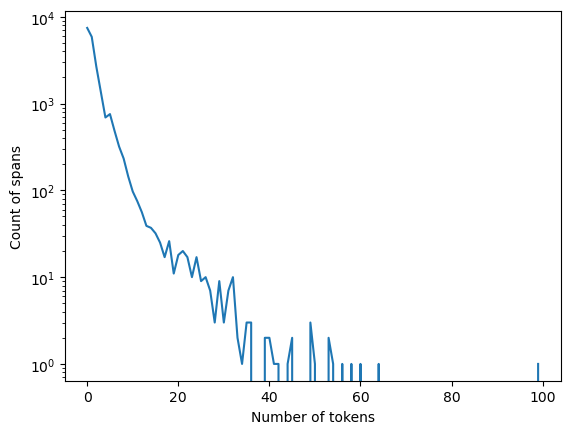

In [15]:
span_len_tokens = stat_corpus.get_span_distro(conditional_rep = total_corpus_dir, return_format = 'list', level = 'token')

fig, ax = plt.subplots()
ax.plot(span_len_tokens)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of spans')
ax.set_yscale('log')
plt.savefig('span_distribution_tokens.png', dpi=300)
plt.show()

#### Span length in number of characters
Distribution of the length of the spans (by character).

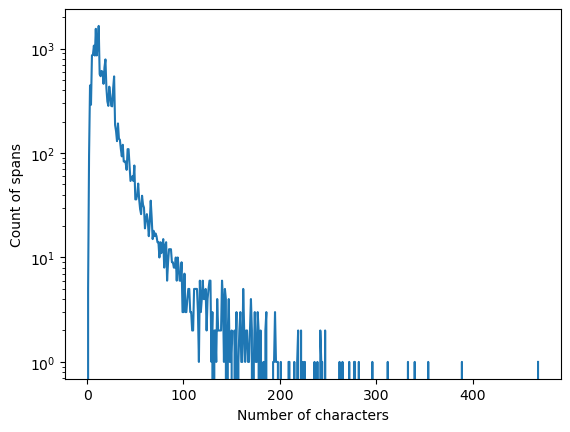

In [16]:
span_len_char = stat_corpus.get_span_distro(conditional_rep = total_corpus_dir, return_format = 'list', level = 'character')

fig, ax = plt.subplots()
ax.plot(span_len_char)
ax.set_xlabel('Number of characters')
ax.set_ylabel('Count of spans')
ax.set_yscale('log')
plt.savefig('span_distribution_char.png', dpi=300)
plt.show()

#### Joint plot

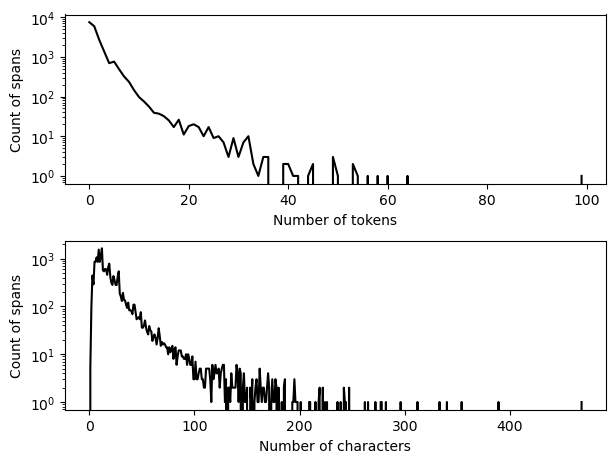

In [17]:
fig, (ax1, ax2) = plt.subplots(2)

fig.tight_layout(pad=2.0) # using padding
#fig.suptitle('Length distribution of spans') # optional

ax1.plot(span_len_tokens, color = "black")
ax1.set_xlabel('Number of tokens')
ax1.set_ylabel('Count of spans')
ax1.set_yscale('log')

ax2.plot(stat_corpus.get_span_distro(conditional_rep = total_corpus_dir, return_format = 'list', level = 'character'), color = "black")
ax2.set_xlabel('Number of characters')
ax2.set_ylabel('Count of spans')
ax2.set_yscale('log')

plt.savefig('span_distribution_both.png', dpi=300)
plt.show()

#### Fraction of spans with 3 or less tokens

In [18]:
sum(span_len_tokens[:3])/sum(span_len_tokens) 

0.7775671866647228

#### A closer look at those long spans
As a robustness check, we take a look at the longest span with almost a hundred tokens.

In [19]:
# Extracting the span list
spanlist_total_corpus = stat_corpus.get_span_list(conditional_rep = total_corpus_dir)

# Counting the length of the strings
entrylen = [len(x.text) for x in spanlist_total_corpus]

# Creating a dataframe that can be sorted by the number of characters in the string
spanlen = pd.DataFrame(data = {"entrylen": entrylen, "spanlist": spanlist_total_corpus})
spanlen = spanlen.sort_values(by = "entrylen", ascending=False)

In [20]:
# Printing the longest span:
print(spanlen.iloc[0,1])

span id:CUR29 annotator:Curation layer:Policydesigncharacteristics feature:Reversibility tag:Reversibility_policy start:1630 stop:2099 text:a delegated act adopted pursuant to article 3(5), article 15(5), article 26(6), article 37(7) and article 40(4) shall enter into force only if no objection has been expressed either by the european parliament or the council within a period of two months of notification of that act to the european parliament and to the council or if, before the expiry of that period, the european parliament and the council have both informed the commission that they will not object.


In [21]:
## Another method for finding longest spans
top_span_count = 3 # the three longest spans
entrylen.sort(reverse = True)
top_spans = [x for x in spanlist_total_corpus if len(x.text) >= entrylen[top_span_count - 1]]
top_spans

[span id:CUR29 annotator:Curation layer:Policydesigncharacteristics feature:Reversibility tag:Reversibility_policy start:1630 stop:2099 text:a delegated act adopted pursuant to article 3(5), article 15(5), article 26(6), article 37(7) and article 40(4) shall enter into force only if no objection has been expressed either by the european parliament or the council within a period of two months of notification of that act to the european parliament and to the council or if, before the expiry of that period, the european parliament and the council have both informed the commission that they will not object.,
 span id:CUR1298 annotator:Curation layer:Instrumenttypes feature:InstrumentType tag:RegulatoryInstr start:2806 stop:3161 text:national support scheme requiring energy producers to include a given proportion of energy from renewable sources in their production, requiring energy suppliers to include a given proportion of energy from renewable sources in their supply, or requiring energy

### Most frequent spans
The legal texts contain many parts that are repeated frequently. Here, we look at which particular spans are annotated most frequently. 

In [22]:
# Function to return a list with the ntags most frequently annotated spans, 
# and the frequency for their occurances in the corpus.
def top_spans(item, value, nspans):
    spans = stat_corpus.most_frequent_labeled_spans(item = item, value = value, conditional_rep = total_corpus_dir)
    top_list = list(spans.items())[:nspans]
    top_dict = dict(top_list)
    # Printing in dictionary format
    print(top_dict) 
    # Converting to list of strings for output, and cleaning the formatting 
    top_span_str = [str(x)[1:-1].replace(",", ":") for x in top_list]
    return top_span_str

#### Misc features and tags

Most frequent spans for form monitoring

In [23]:
Form_monitoring_top = top_spans(item = 'tag', value = 'Form_monitoring', nspans = 15)

{'report': 146, 'reporting': 79, 'assessment': 68, 'review': 63, 'information': 58, 'notification': 57, 'monitoring': 46, 'reports': 46, 'projections': 39, 'notify': 33, 'reported': 32, 'monitor': 27, 'assess': 25, 'inventory': 24, 'notified': 21}


Most frequent spans for regulatory instrument

In [24]:
RegulatoryInstr_top = top_spans(item = 'tag', value = 'RegulatoryInstr', nspans = 15)

{'requirements': 92, 'obligations': 65, 'rules': 49, 'derogation': 48, 'obligation': 25, 'regulations': 24, 'standards': 24, 'certification': 23, 'criteria': 21, 'technical specifications': 19, 'sustainability criteria': 15, 'type-approval': 14, 'right': 14, 'regulatory procedure': 14, 'guarantees of origin': 13}


Most frequent spans for addressee sector

In [25]:
ActorSector_top_str = top_spans(item = 'tag', value = 'Addressee_sector', nspans = 15)

{'transmission system operator': 91, 'distribution system operators': 69, 'transmission system operators': 68, 'manufacturer': 52, 'suppliers': 41, 'distribution system operator': 37, 'manufacturers': 34, 'final customers': 31, 'supplier': 28, 'transport sector': 24, 'transport': 23, 'independent system operator': 23, 'market participants': 19, 'electricity undertakings': 16, 'producers': 15}


Most frequent spans for the actor feature

In [26]:
Actor_top_str = top_spans(item = 'feature', value = 'Actor', nspans = 15)

{'member states': 901, 'commission': 757, 'member state': 277, 'member\xa0states': 260, 'european parliament': 167, 'council': 164, 'regulatory authority': 144, 'transmission system operator': 111, 'final customers': 102, 'member\xa0state': 92, 'customers': 86, 'transmission system operators': 85, 'distribution system operators': 81, 'manufacturer': 63, 'regulatory authorities': 54}


Most frequent spans for the quantitative targets

In [27]:
top_spans(item = 'tag', value = 'Objective_QuantTarget', nspans = 15)

{'specific emissions target': 14, 'target': 9, 'targets': 7, 'union target': 6, 'specific emissions targets': 4, 'national indicative energy savings target': 3, 'eu fleet-wide targets': 3, 'national contributions': 2, 'baseline share': 2, 'energy consumption of no more than 1\xa0474 mtoe of primary energy and/or no more than 1\xa0078 mtoe of final energy in 2020': 2, 'national indicative targets': 2, 'eu fleet-wide target equal to a 15\xa0% reduction': 2, 'national targets': 2, 'target of at least 32\xa0% renewable energy in 2030': 2, 'annual renovation rate': 2}


["'specific emissions target': 14",
 "'target': 9",
 "'targets': 7",
 "'union target': 6",
 "'specific emissions targets': 4",
 "'national indicative energy savings target': 3",
 "'eu fleet-wide targets': 3",
 "'national contributions': 2",
 "'baseline share': 2",
 "'energy consumption of no more than 1\\xa0474 mtoe of primary energy and/or no more than 1\\xa0078 mtoe of final energy in 2020': 2",
 "'national indicative targets': 2",
 "'eu fleet-wide target equal to a 15\\xa0% reduction': 2",
 "'national targets': 2",
 "'target of at least 32\\xa0% renewable energy in 2030': 2",
 "'annual renovation rate': 2"]

Most frequent spans for the reversibility feature

In [28]:
top_spans(item = 'feature', value = 'Reversibility', nspans = 15)

{'repealed': 4, 'extension': 3, 'a decision to revoke shall put an end to the delegation of the power specified in that decision': 2, 'repealing': 2, 'extended by two months': 2, 'may be revoked at any time by the european parliament or by the council': 2, 'deleted': 2, 'repeal': 2, 'delegation of power shall be tacitly extended for periods of an identical duration, unless the european parliament or the council opposes such extension not later than three months before the end of each period': 1, 'the delegation of power referred to in article 3(5), article 15(5), article 26(6), article 37(7) and article 40(4) may be revoked at any time by the european parliament or by the council': 1, 'a delegated act adopted pursuant to article 3(5), article 15(5), article 26(6), article 37(7) and article 40(4) shall enter into force only if no objection has been expressed either by the european parliament or the council within a period of two months of notification of that act to the european parliam

["'repealed': 4",
 "'extension': 3",
 "'a decision to revoke shall put an end to the delegation of the power specified in that decision': 2",
 "'repealing': 2",
 "'extended by two months': 2",
 "'may be revoked at any time by the european parliament or by the council': 2",
 "'deleted': 2",
 "'repeal': 2",
 "'delegation of power shall be tacitly extended for periods of an identical duration: unless the european parliament or the council opposes such extension not later than three months before the end of each period': 1",
 "'the delegation of power referred to in article 3(5): article 15(5): article 26(6): article 37(7) and article 40(4) may be revoked at any time by the european parliament or by the council': 1",
 "'a delegated act adopted pursuant to article 3(5): article 15(5): article 26(6): article 37(7) and article 40(4) shall enter into force only if no objection has been expressed either by the european parliament or the council within a period of two months of notification of t

Generating the table with other features and tags as a Latex output.

In [29]:
other_top = pd.DataFrame({'Form_monitoring': Form_monitoring_top, 'RegulatoryInstr': RegulatoryInstr_top, 'Actor': Actor_top_str, 'ActorSector': ActorSector_top_str})
other_top.to_latex(index=False)

/tmp/ipykernel_46123/1869844980.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  other_top.to_latex(index=False)


"\\begin{tabular}{llll}\n\\toprule\n   Form\\_monitoring &                RegulatoryInstr &                               Actor &                         ActorSector \\\\\n\\midrule\n     'report': 146 &             'requirements': 92 &                'member states': 901 &  'transmission system operator': 91 \\\\\n   'reporting': 79 &              'obligations': 65 &                   'commission': 757 & 'distribution system operators': 69 \\\\\n  'assessment': 68 &                    'rules': 49 &                 'member state': 277 & 'transmission system operators': 68 \\\\\n      'review': 63 &               'derogation': 48 &             'member\\textbackslash xa0states': 260 &                  'manufacturer': 52 \\\\\n 'information': 58 &               'obligation': 25 &          'european parliament': 167 &                     'suppliers': 41 \\\\\n'notification': 57 &              'regulations': 24 &                      'council': 164 &  'distribution system operator': 37 \\\\

#### Technology, energy, and application specificity

Most frequent spans for low-carbon technology

In [30]:
tech_top_str = top_spans(item = 'tag', value = 'Tech_LowCarbon', nspans = 15)

{'energy efficiency': 87, 'cogeneration': 61, 'batteries': 56, 'accumulators': 56, 'installation': 36, 'recharging points': 36, 'high-efficiency cogeneration': 34, 'district heating and cooling': 23, 'energy storage facilities': 22, 'smart metering systems': 22, 'renovation': 22, 'battery': 16, 'installations': 16, 'hydrogen components and systems': 15, 'batteries and accumulators': 13}


Most frequent spans for other technology

In [31]:
tech_top_str = top_spans(item = 'tag', value = 'Tech_Other', nspans = 15)

{'buildings': 49, 'passenger cars': 35, 'transmission system': 35, 'system': 31, 'grid': 29, 'building': 29, 'light commercial vehicles': 28, 'distribution system': 22, 'new passenger cars': 20, 'new light commercial vehicles': 19, 'network': 19, 'vehicles': 17, 'installations': 14, 'vehicle': 12, 'infrastructure': 11}


Most frequent spans for energy carrier low carbon

In [32]:
energy_top_str = top_spans(item = 'tag', value = 'Energy_LowCarbon', nspans = 15)

{'renewable energy': 159, 'energy from renewable sources': 157, 'biofuels': 125, 'bioliquids': 92, 'electricity': 82, 'hydrogen': 68, 'biomass fuels': 60, 'renewable energy sources': 40, 'biomass': 39, 'electricity from renewable sources': 31, 'biofuel': 23, 'biogas': 21, 'alternative fuels': 17, 'waste heat and cold': 17, 'renewable sources': 16}


Most frequent spans for application specificity low carbon

In [33]:
applications_top_str = top_spans(item = 'tag', value = 'App_LowCarbon', nspans = 15)

{'heating': 78, 'cooling': 78, 'energy savings': 54, 'demand response': 27, 'renewable energy communities': 19, 'energy storage': 14, 'energy efficiency': 13, 'electric vehicles': 12, 'electricity': 12, 'transport': 12, 'vehicles': 10, 'renewables self-consumption': 10, 'vehicle': 9, 'primary energy savings': 8, 'final consumption of energy from renewable sources': 7}


Most frequent spans for the feature energy specificity (low carbon and other together)

In [34]:
energy_top_str = top_spans(item = 'feature', value = 'EnergySpecificity', nspans = 15)

{'electricity': 199, 'renewable energy': 159, 'energy from renewable sources': 157, 'biofuels': 125, 'energy': 121, 'bioliquids': 92, 'hydrogen': 68, 'biomass fuels': 61, 'renewable energy sources': 40, 'biomass': 39, 'electricity from renewable sources': 31, 'fuel': 28, 'heat': 25, 'lng': 25, 'natural gas': 24}


Most frequent spans for the feature application specificity (low carbon and other together)

In [35]:
energy_top_str = top_spans(item = 'feature', value = 'ApplicationSpecificity', nspans = 15)

{'heating': 98, 'cooling': 94, 'energy savings': 61, 'supply': 49, 'energy consumption': 36, 'consumption': 31, 'aggregation': 30, 'demand response': 28, 'generation': 26, 'energy services': 25, 'transport': 23, 'distribution': 22, 'transmission': 21, 'renewable energy communities': 19, 'energy storage': 14}


Generating the table on tech, energy, and application specificity as a Latex output.

In [36]:
df_tech_top = pd.DataFrame({'technology_LowCarbon': tech_top_str, 'energy_LowCarbon': energy_top_str, 'applications_LowCarbon': applications_top_str})
df_tech_top.to_latex(index=False)

/tmp/ipykernel_46123/852186205.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_tech_top.to_latex(index=False)


"\\begin{tabular}{lll}\n\\toprule\n               technology\\_LowCarbon &                   energy\\_LowCarbon &                             applications\\_LowCarbon \\\\\n\\midrule\n                    'buildings': 49 &                      'heating': 98 &                                      'heating': 78 \\\\\n               'passenger cars': 35 &                      'cooling': 94 &                                      'cooling': 78 \\\\\n          'transmission system': 35 &               'energy savings': 61 &                               'energy savings': 54 \\\\\n                       'system': 31 &                       'supply': 49 &                              'demand response': 27 \\\\\n                         'grid': 29 &           'energy consumption': 36 &                 'renewable energy communities': 19 \\\\\n                     'building': 29 &                  'consumption': 31 &                               'energy storage': 14 \\\\\n    'light commercial ve

### Distributions of annotations

#### Importing the coding scheme
The coding scheme with all layers, features, and tags is supplied in the repository. 

In [39]:
import json

with open('Coding_Scheme.json','r') as f: # Insert path to coding scheme file
    coding_scheme = json.loads(f.read())

FileNotFoundError: [Errno 2] No such file or directory: 'Coding_Scheme.json'

#### Function to count the annotations per layer, feature, and tag
A function that creates a dataframe with layer, feature, tags, and the respective number of annotations.
Input: The name of the layer as it should appear in the dataframe, the index of the layer in the coding scheme (as imported above)
Output: A dataframe with the number of annotations per feature and tag in this layer (layer, feature, tag, n_feature, n_tag)

In [78]:
def annotation_count(layername, layer_index):

    # Reading out the feature names and removing the '_values' from the end of the string
    feat_list = [x['tagset'][:-7] for x in coding_scheme['layers'][layer_index]['tagsets']]
    feat_list

    # Computing the number of annotations per feature
    n_feat_list = list()
    for feat in feat_list:
        n_feat = stat_corpus.get_span_count(item = 'feature',value = feat, conditional_rep = total_corpus_dir)
        n_feat_list.append(n_feat)

    df_list = list()
    for f in range(len(coding_scheme['layers'][layer_index]['tagsets'])):
        tags = [x['tag_name'] for x in coding_scheme['layers'][layer_index]['tagsets'][f]['tags']]

        df_loc = pd.DataFrame(data = {"tag": tags})
        df_loc.insert(0, 'feature', feat_list[f])
        df_loc.insert(2, 'n_feature', stat_corpus.get_span_count(item = 'feature',value = feat_list[f], 
                                                                  conditional_rep = total_corpus_dir))
        # Also reading out the count for the tags
        n_tags = [stat_corpus.get_span_count(item = 'tag',value = tag_loc, conditional_rep = total_corpus_dir) for tag_loc in df_loc['tag']]
        df_loc.insert(3, 'n_tag',n_tags)

        # Creating a list of the dataframes by feature
        df_list.append(df_loc)

    n_df = pd.concat(df_list)
    n_df.insert(0, 'layer', layername)
    return n_df

#### Counts per layer

In [314]:
n_instr = stat_corpus.get_span_count(item = 'layer',value = 'Instrumenttypes', conditional_rep = total_corpus_dir)
n_pdc = stat_corpus.get_span_count(item = 'layer',value = 'Policydesigncharacteristics', conditional_rep = total_corpus_dir)
n_techspec = stat_corpus.get_span_count(item = 'layer',value = 'Technologyandapplicationspecificity', conditional_rep = total_corpus_dir)

#### Counts for instrument types

In [79]:
n_instr_df = annotation_count(layername = 'Instrument types', layer_index = 2)
n_instr_df

,layer,feature,tag,n_feature,n_tag
0,Instrument types,InstrumentType,Edu_Outreach,3374,328
1,Instrument types,InstrumentType,FrameworkPolicy,3374,318
2,Instrument types,InstrumentType,PublicInvt,3374,97
3,Instrument types,InstrumentType,RD_D,3374,12
4,Instrument types,InstrumentType,RegulatoryInstr,3374,1225
5,Instrument types,InstrumentType,Subsidies_Incentives,3374,102
6,Instrument types,InstrumentType,TaxIncentives,3374,78
7,Instrument types,InstrumentType,TradablePermit,3374,143
8,Instrument types,InstrumentType,Unspecified,3374,1099
9,Instrument types,InstrumentType,VoluntaryAgrmt,3374,70


#### Counts for policy design characteristics

In [80]:
n_pdc_df = annotation_count(layername = '    Policy design characteristics    ', layer_index = 0)
n_pdc_df

,layer,feature,tag,n_feature,n_tag
0,Policy design characteristics,Objective,Objective_QualIntention,990,554
1,Policy design characteristics,Objective,Objective_QualIntention_noCCM,990,266
2,Policy design characteristics,Objective,Objective_QuantTarget,990,162
3,Policy design characteristics,Objective,Objective_QuantTarget_noCCM,990,8
0,Policy design characteristics,Reference,Ref_OtherPolicy,1108,736
1,Policy design characteristics,Reference,Ref_PolicyAmended,1108,90
2,Policy design characteristics,Reference,Ref_Strategy_Agreement,1108,282
0,Policy design characteristics,Actor,Addressee_default,5873,2079
1,Policy design characteristics,Actor,Addressee_monitored,5873,483
2,Policy design characteristics,Actor,Addressee_resource,5873,142


#### Counts for technology specificity

In [85]:
n_techspec_df = annotation_count(layername = 'Technology specificity', layer_index = 1)
n_techspec_df

,layer,feature,tag,n_feature,n_tag
0,Technology specificity,EnergySpecificity,Energy_LowCarbon,1901,1353
1,Technology specificity,EnergySpecificity,Energy_Other,1901,548
0,Technology specificity,ApplicationSpecificity,App_LowCarbon,1543,759
1,Technology specificity,ApplicationSpecificity,App_Other,1543,784
0,Technology specificity,TechnologySpecificity,Tech_LowCarbon,2511,1460
1,Technology specificity,TechnologySpecificity,Tech_Other,2511,1051


### Distribution of annotations for individiual features and tags

Sunburst plot of all three levels of the hierarchy


In [92]:
df = pd.concat([n_instr_df, n_pdc_df, n_techspec_df])

In [93]:
fig = px.sunburst(df, path=['layer', 'feature', 'tag'], values='n_tag', color='layer', 
                  color_discrete_sequence = px.colors.qualitative.Set3[4:7])
fig.write_image('ann_distribution_sunburst.pdf', engine = "orca")
fig.show()

/Users/l.kaack/miniconda3/envs/policycoding/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/l.kaack/miniconda3/envs/policycoding/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/l.kaack/miniconda3/envs/policycoding/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

